In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import copy
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   

os.environ["CUDA_VISIBLE_DEVICES"]="3"

import matplotlib.pyplot as plt
import torch.optim as optim


In [2]:
torch.manual_seed(0)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
CIFAR_SGD_trainloader = torch.utils.data.DataLoader(trainset, batch_size=500,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=8)


Files already downloaded and verified
Files already downloaded and verified


In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #print(npimg)
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(np.transpose(npimg))#, (1, 2, 0)))
    plt.show()

In [8]:
'''for i in range(5):
    tmp=trainset[i]
    fig=plt.figure
    plt.imshow(np.transpose(tmp[0],(1,2,0)))
    plt.show()
    print(classes[tmp[1]])'''

'for i in range(5):\n    tmp=trainset[i]\n    fig=plt.figure\n    plt.imshow(np.transpose(tmp[0],(1,2,0)))\n    plt.show()\n    print(classes[tmp[1]])'

In [9]:
'''# get some random training images
dataiter = iter(CIFAR_SGD_trainloader)
images, labels = dataiter.next()
print(images.shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
# print size of single image
print(images[1].shape)'''

"# get some random training images\ndataiter = iter(CIFAR_SGD_trainloader)\nimages, labels = dataiter.next()\nprint(images.shape)\n# show images\nimshow(torchvision.utils.make_grid(images))\n# print labels\nprint(' '.join('%5s' % classes[labels[j]] for j in range(4)))\n# print size of single image\nprint(images[1].shape)"

In [10]:
class DatasetSplit(Dataset):
    """An abstract Dataset class wrapped around Pytorch Dataset class.
    """

    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return torch.tensor(image), torch.tensor(label)

In [11]:
def cifar_iid(dataset, num_users):
    """
    Sample I.I.D. client data from CIFAR10 dataset
    :param dataset:
    :param num_users:
    :return: dict of image index
    """
    num_items = int(len(dataset)/num_users)
    #num_items=8
    dict_users, all_idxs = {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items, replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    return dict_users

In [36]:
def cifar_dirichlet(dataset, n_nets, alpha=0.5):
    '''
    if dataset == 'mnist':
        X_train, y_train, X_test, y_test = load_mnist_data(datadir)
    elif dataset == 'cifar10':
        X_train, y_train, X_test, y_test = load_cifar10_data(datadir)
    '''
    #X_train=dataset[:][0]
    y_train=torch.zeros(len(dataset),dtype=torch.long)
    print(y_train.dtype)
    for a in range(len(dataset)):
        y_train[a]=(dataset[a][1])
    n_train = len(dataset)
    #X_train.shape[0]
    '''
    if partition == "homo":
        idxs = np.random.permutation(n_train)
        batch_idxs = np.array_split(idxs, n_nets)
        net_dataidx_map = {i: batch_idxs[i] for i in range(n_nets)}
    '''
    #elif partition == "hetero-dir":
    min_size = 0
    K = 10
    N=len(dataset)
    N = y_train.shape[0]
    net_dataidx_map = {i: np.array([],dtype='int64') for i in range(n_nets)}

    while min_size < 10:
        idx_batch = [[] for _ in range(n_nets)]
        for k in range(K):
            idx_k = np.where(y_train == k)[0]
            np.random.shuffle(idx_k)
            proportions = np.random.dirichlet(np.repeat(alpha, n_nets))
            ## Balance
            proportions = np.array([p*(len(idx_j)<N/n_nets) for p,idx_j in zip(proportions,idx_batch)])
            proportions = proportions/proportions.sum()
            proportions = (np.cumsum(proportions)*len(idx_k)).astype(int)[:-1]
            idx_batch = [idx_j + idx.tolist() for idx_j,idx in zip(idx_batch,np.split(idx_k,proportions))]
            min_size = min([len(idx_j) for idx_j in idx_batch])

        for j in range(n_nets):
            np.random.shuffle(idx_batch[j])
            net_dataidx_map[j] = idx_batch[j]

    #traindata_cls_counts = record_net_data_stats(y_train, net_dataidx_map, logdir)
    return net_dataidx_map
    #return (X_train, y_train, X_test, y_test, net_dataidx_map, traindata_cls_counts)

In [12]:
'''cifar_iid_dataset=cifar_iid(trainset,2)
print(cifar_iid_dataset)'''

'cifar_iid_dataset=cifar_iid(trainset,2)\nprint(cifar_iid_dataset)'

In [13]:
'''num_clients=2
num_items=8

for x in range(num_clients):
    print(f"This is {x} client")
    index_list=list(cifar_iid_dataset[x])
    CIFAR_client_trainloader=DataLoader(DatasetSplit(trainset,index_list),batch_size=4,shuffle=False,num_workers=2)
    dataiter=iter(CIFAR_client_trainloader)
    for i in range(int(num_items/4)):
        images,labels=dataiter.next()
        print(images.shape)
        #print(trainset[index_list[i]])
        #print(image)
        fig=plt.figure
        imshow(torchvision.utils.make_grid(images))
        print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
        #print(classes[trainset[index_list[i]][1]])'''

'num_clients=2\nnum_items=8\n\nfor x in range(num_clients):\n    print(f"This is {x} client")\n    index_list=list(cifar_iid_dataset[x])\n    CIFAR_client_trainloader=DataLoader(DatasetSplit(trainset,index_list),batch_size=4,shuffle=False,num_workers=2)\n    dataiter=iter(CIFAR_client_trainloader)\n    for i in range(int(num_items/4)):\n        images,labels=dataiter.next()\n        print(images.shape)\n        #print(trainset[index_list[i]])\n        #print(image)\n        fig=plt.figure\n        imshow(torchvision.utils.make_grid(images))\n        print(\' \'.join(\'%5s\' % classes[labels[j]] for j in range(4)))\n        #print(classes[trainset[index_list[i]][1]])'

In [14]:
'''num_clients=2
num_items=5

for x in range(num_clients):
    print(f"This is {x} client")
    index_list=list(cifar_iid_dataset[x])
    for i in range(num_items):
        image=trainset[index_list[i]][0]
        #print(trainset[index_list[i]])
        #print(image)
        fig=plt.figure
        plt.imshow(np.transpose(image,(1,2,0)))
        plt.show()
        print(classes[trainset[index_list[i]][1]])'''

'num_clients=2\nnum_items=5\n\nfor x in range(num_clients):\n    print(f"This is {x} client")\n    index_list=list(cifar_iid_dataset[x])\n    for i in range(num_items):\n        image=trainset[index_list[i]][0]\n        #print(trainset[index_list[i]])\n        #print(image)\n        fig=plt.figure\n        plt.imshow(np.transpose(image,(1,2,0)))\n        plt.show()\n        print(classes[trainset[index_list[i]][1]])'

In [15]:
def cifar_noniid(dataset, num_users):
    """
    Sample non-I.I.D client data from CIFAR10 dataset
    :param dataset:
    :param num_users:
    :return:
    """
    #num_shards, num_imgs = 200, 250
    #num_shards, num_imgs = 200, 250
    class_per_user=1
    num_shards=num_users*class_per_user
    num_imgs=int(len(dataset)/num_shards)
    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([],dtype='int64') for i in range(num_users)}
    idxs = np.arange(num_shards*num_imgs)
    # labels = dataset.train_labels.numpy()
    #labels = np.array(dataset.train_labels)

    labels=[]
    for element in dataset:
        labels.append(int(element[1]))
    #print(type(labels[0]))
    labels=np.array(labels)
    #labels=labels.astype('int64')
    # sort labels
    
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
    idxs = idxs_labels[0, :]

    # divide and assign
    for i in range(num_users):
        rand_set = set(np.random.choice(idx_shard, class_per_user, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        for rand in rand_set:
            dict_users[i] = np.concatenate(
                (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0)
    return dict_users

In [16]:
'''cifar_noniid_dataset=cifar_noniid(trainset,2)
print(cifar_noniid_dataset)'''

'cifar_noniid_dataset=cifar_noniid(trainset,2)\nprint(cifar_noniid_dataset)'

In [17]:
'''num_clients=2
num_items=250*2

for x in range(num_clients):
    print(f"This is {x} client")
    index_list=list(cifar_noniid_dataset[x])
    CIFAR_client_trainloader=DataLoader(DatasetSplit(trainset,index_list),batch_size=4,shuffle=False,num_workers=2)
    dataiter=iter(CIFAR_client_trainloader)
    for i in range(int(num_items/4)):
        images,labels=dataiter.next()
        print(images.shape)
        #print(trainset[index_list[i]])
        #print(image)
        fig=plt.figure
        imshow(torchvision.utils.make_grid(images))
        print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
        #print(classes[trainset[index_list[i]][1]])'''

'num_clients=2\nnum_items=250*2\n\nfor x in range(num_clients):\n    print(f"This is {x} client")\n    index_list=list(cifar_noniid_dataset[x])\n    CIFAR_client_trainloader=DataLoader(DatasetSplit(trainset,index_list),batch_size=4,shuffle=False,num_workers=2)\n    dataiter=iter(CIFAR_client_trainloader)\n    for i in range(int(num_items/4)):\n        images,labels=dataiter.next()\n        print(images.shape)\n        #print(trainset[index_list[i]])\n        #print(image)\n        fig=plt.figure\n        imshow(torchvision.utils.make_grid(images))\n        print(\' \'.join(\'%5s\' % classes[labels[j]] for j in range(4)))\n        #print(classes[trainset[index_list[i]][1]])'

In [18]:
'''num_clients=2
num_items=5
num_imgs=250
cifar_noniid_dataset=cifar_noniid(trainset, num_clients)
#print(cifar_noniid_dataset)
for x in range(num_clients):
    print(f"This is {x} client")
    index_list=list(cifar_noniid_dataset[x])
    #print(index_list)
    #print(index_list[0])
    #print(type(index_list[0]))
    for y in range(2):
        for i in range(num_items):
            image=trainset[index_list[i+num_imgs*y]][0]
            #print(image)
            fig=plt.figure
            plt.imshow(np.transpose(image,(1,2,0)))
            plt.show()
            print(classes[trainset[index_list[i+num_imgs*y]][1]])'''

'num_clients=2\nnum_items=5\nnum_imgs=250\ncifar_noniid_dataset=cifar_noniid(trainset, num_clients)\n#print(cifar_noniid_dataset)\nfor x in range(num_clients):\n    print(f"This is {x} client")\n    index_list=list(cifar_noniid_dataset[x])\n    #print(index_list)\n    #print(index_list[0])\n    #print(type(index_list[0]))\n    for y in range(2):\n        for i in range(num_items):\n            image=trainset[index_list[i+num_imgs*y]][0]\n            #print(image)\n            fig=plt.figure\n            plt.imshow(np.transpose(image,(1,2,0)))\n            plt.show()\n            print(classes[trainset[index_list[i+num_imgs*y]][1]])'

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        #self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = (F.relu(self.conv3(x)))
        x = x.view(-1, 64*4*4)
        x = F.relu(self.fc1(x))
        x = (self.fc2(x))
        
        return x




In [20]:
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,momentum=0.5)
loss_train = []
acc_train=[]

In [22]:
for epoch in range(0):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(CIFAR_SGD_trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data[0].to(device), data[1].to(device)
        #print(labels)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        #print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
       
        
    if epoch%1==0:
        loss_train.append(loss)
        print(f"epoch: {epoch}")
        print(' Average loss {:.3f}'.format( loss))
        for j in range(1):
            net.eval()         
            correct = 0
            total = 0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data[0].to(device), data[1].to(device)
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %d %%' % (
                100 * correct / total))
        acc_train.append(100 * correct / total)

    net.train()

    '''# 통계를 출력합니다.
    running_loss += loss.item()
    if i % 2000 == 1999:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0'''

print('Finished Training')

Finished Training


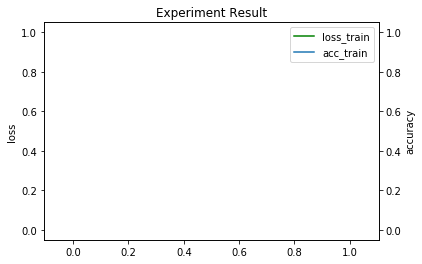

In [23]:
fig,ax1=plt.subplots()
ax2=ax1.twinx()
line1=ax1.plot(np.array(loss_train),color='g',label='loss_train')
line2=ax2.plot([i*1 for i in range(len(acc_train))],acc_train,label='acc_train')
lines=line1+line2
ax1.set_ylabel("loss")
ax2.set_ylabel("accuracy")
plt.xlabel('Epoch')
plt.title('Experiment Result')
plt.legend(lines,['loss_train','acc_train'])
plt.show()

In [24]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


/home/dana/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Accuracy of the network on the 10000 test images: 10 %


In [25]:
class LocalUpdate(object):
    def __init__(self, lr,local_epoch,device,batch_size, dataset=None, idxs=None):
        self.lr=lr
        self.local_epoch=local_epoch
        self.device=device
        self.loss_func = nn.CrossEntropyLoss()
        self.selected_clients = []
        self.ldr_train = DataLoader(DatasetSplit(dataset, idxs), batch_size=batch_size, shuffle=True)

    def train(self, net):
        net.train()
        # train and update
        optimizer = torch.optim.SGD(net.parameters(), lr=self.lr)

        epoch_loss = []
        for iter in range(self.local_epoch):
            batch_loss = []
            for batch_idx, (images, labels) in enumerate(self.ldr_train):
                images, labels = images.to(self.device), labels.to(self.device)
                net.zero_grad()
                log_probs = net(images)
                loss = self.loss_func(log_probs, labels)
                loss.backward()
                optimizer.step()
                #if batch_idx % 10 == 0:
                #    print('Update Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #        iter, batch_idx * len(images), len(self.ldr_train.dataset),
                #               100. * batch_idx / len(self.ldr_train), loss.item()))
                batch_loss.append(loss.item())
            epoch_loss.append(sum(batch_loss)/len(batch_loss))
        return net.state_dict(), sum(epoch_loss) / len(epoch_loss)

cifar10 FedAvg iid로 학습

In [26]:
device=torch.device('cuda')
FedAvg_model=Net().cuda()
criterion= nn.CrossEntropyLoss().to(device)
FedAvg_model.train()
epoch_loss = []

# Set optimizer for the local updates

optimizer = torch.optim.SGD(FedAvg_model.parameters(), lr=0.001,
                                momentum=0.9)
global_epoch=501

In [27]:
weight_saved=FedAvg_model.state_dict()

In [28]:
C=0.05
num_clients=100
#CIFAR_noniid_dataset=cifar_noniid(trainset, num_clients)
CIFAR_iid_dataset=cifar_iid(trainset, num_clients)
loss_train = []
acc_train=[]

In [29]:
for epoch in range(global_epoch):
    local_weight=[]
    local_loss=[]
    m=max(int(C*num_clients),1)
    selected_user=np.random.choice(range(num_clients),m,replace=False)
    print(f"This is global {epoch} epoch")
    for user in selected_user:
        local_setting=LocalUpdate(lr=0.1,local_epoch=1,device=device,batch_size=40,dataset=trainset, idxs=CIFAR_iid_dataset[user])
        weight,loss=local_setting.train(net=copy.deepcopy(FedAvg_model).to(device))
        local_weight.append(copy.deepcopy(weight))
        #print(local_weight[0].keys())
        local_loss.append(copy.deepcopy(loss))
    FedAvg_weight=copy.deepcopy(local_weight[0])
    for key in FedAvg_weight.keys():
        for i in range(1,len(local_weight)):
            FedAvg_weight[key]+=local_weight[i][key]
        FedAvg_weight[key]/=len(local_weight)
    FedAvg_model.load_state_dict(FedAvg_weight)
    loss_avg = sum(local_loss) / len(local_loss)
    print(' Average loss {:.3f}'.format( loss_avg))
    loss_train.append(loss_avg)
    if epoch%1==0:
        for j in range(1):
            FedAvg_model.eval()         
            correct = 0
            total = 0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data[0].to(device), data[1].to(device)
                    outputs = FedAvg_model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %f %%' % (
                100 * correct / float(total)))
        acc_train.append(100 * correct / float(total))
 
    FedAvg_model.train()

This is global 0 epoch


/home/dana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


 Average loss 2.303
Accuracy of the network on the 10000 test images: 13.060000 %
This is global 1 epoch
 Average loss 2.303
Accuracy of the network on the 10000 test images: 10.150000 %
This is global 2 epoch
 Average loss 2.296
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3 epoch
 Average loss 2.290
Accuracy of the network on the 10000 test images: 9.980000 %
This is global 4 epoch
 Average loss 2.279
Accuracy of the network on the 10000 test images: 16.260000 %
This is global 5 epoch
 Average loss 2.243
Accuracy of the network on the 10000 test images: 19.830000 %
This is global 6 epoch
 Average loss 2.183
Accuracy of the network on the 10000 test images: 20.500000 %
This is global 7 epoch
 Average loss 2.142
Accuracy of the network on the 10000 test images: 22.830000 %
This is global 8 epoch
 Average loss 2.091
Accuracy of the network on the 10000 test images: 24.690000 %
This is global 9 epoch
 Average loss 2.108
Accuracy of the network on the 10000

 Average loss 1.393
Accuracy of the network on the 10000 test images: 52.330000 %
This is global 79 epoch
 Average loss 1.379
Accuracy of the network on the 10000 test images: 52.620000 %
This is global 80 epoch
 Average loss 1.397
Accuracy of the network on the 10000 test images: 52.170000 %
This is global 81 epoch
 Average loss 1.414
Accuracy of the network on the 10000 test images: 52.420000 %
This is global 82 epoch
 Average loss 1.370
Accuracy of the network on the 10000 test images: 53.510000 %
This is global 83 epoch
 Average loss 1.377
Accuracy of the network on the 10000 test images: 52.780000 %
This is global 84 epoch
 Average loss 1.337
Accuracy of the network on the 10000 test images: 53.210000 %
This is global 85 epoch
 Average loss 1.378
Accuracy of the network on the 10000 test images: 53.090000 %
This is global 86 epoch
 Average loss 1.341
Accuracy of the network on the 10000 test images: 54.250000 %
This is global 87 epoch
 Average loss 1.332
Accuracy of the network on

 Average loss 1.130
Accuracy of the network on the 10000 test images: 61.540000 %
This is global 156 epoch
 Average loss 1.086
Accuracy of the network on the 10000 test images: 61.730000 %
This is global 157 epoch
 Average loss 1.036
Accuracy of the network on the 10000 test images: 62.350000 %
This is global 158 epoch
 Average loss 1.085
Accuracy of the network on the 10000 test images: 62.540000 %
This is global 159 epoch
 Average loss 1.107
Accuracy of the network on the 10000 test images: 62.130000 %
This is global 160 epoch
 Average loss 1.051
Accuracy of the network on the 10000 test images: 62.440000 %
This is global 161 epoch
 Average loss 1.085
Accuracy of the network on the 10000 test images: 62.420000 %
This is global 162 epoch
 Average loss 1.037
Accuracy of the network on the 10000 test images: 63.030000 %
This is global 163 epoch
 Average loss 1.094
Accuracy of the network on the 10000 test images: 63.130000 %
This is global 164 epoch
 Average loss 1.041
Accuracy of the n

 Average loss 0.922
Accuracy of the network on the 10000 test images: 66.740000 %
This is global 233 epoch
 Average loss 0.860
Accuracy of the network on the 10000 test images: 66.820000 %
This is global 234 epoch
 Average loss 0.962
Accuracy of the network on the 10000 test images: 68.210000 %
This is global 235 epoch
 Average loss 0.860
Accuracy of the network on the 10000 test images: 66.480000 %
This is global 236 epoch
 Average loss 0.840
Accuracy of the network on the 10000 test images: 68.340000 %
This is global 237 epoch
 Average loss 0.935
Accuracy of the network on the 10000 test images: 68.440000 %
This is global 238 epoch
 Average loss 0.879
Accuracy of the network on the 10000 test images: 67.530000 %
This is global 239 epoch
 Average loss 0.896
Accuracy of the network on the 10000 test images: 67.540000 %
This is global 240 epoch
 Average loss 0.838
Accuracy of the network on the 10000 test images: 68.310000 %
This is global 241 epoch
 Average loss 0.856
Accuracy of the n

 Average loss 0.747
Accuracy of the network on the 10000 test images: 69.840000 %
This is global 310 epoch
 Average loss 0.733
Accuracy of the network on the 10000 test images: 69.620000 %
This is global 311 epoch
 Average loss 0.757
Accuracy of the network on the 10000 test images: 70.250000 %
This is global 312 epoch
 Average loss 0.705
Accuracy of the network on the 10000 test images: 69.710000 %
This is global 313 epoch
 Average loss 0.672
Accuracy of the network on the 10000 test images: 69.830000 %
This is global 314 epoch
 Average loss 0.689
Accuracy of the network on the 10000 test images: 70.850000 %
This is global 315 epoch
 Average loss 0.728
Accuracy of the network on the 10000 test images: 70.020000 %
This is global 316 epoch
 Average loss 0.619
Accuracy of the network on the 10000 test images: 70.360000 %
This is global 317 epoch
 Average loss 0.794
Accuracy of the network on the 10000 test images: 70.220000 %
This is global 318 epoch
 Average loss 0.684
Accuracy of the n

 Average loss 0.612
Accuracy of the network on the 10000 test images: 70.690000 %
This is global 387 epoch
 Average loss 0.593
Accuracy of the network on the 10000 test images: 71.020000 %
This is global 388 epoch
 Average loss 0.661
Accuracy of the network on the 10000 test images: 71.590000 %
This is global 389 epoch
 Average loss 0.675
Accuracy of the network on the 10000 test images: 70.970000 %
This is global 390 epoch
 Average loss 0.587
Accuracy of the network on the 10000 test images: 68.810000 %
This is global 391 epoch
 Average loss 0.514
Accuracy of the network on the 10000 test images: 71.610000 %
This is global 392 epoch
 Average loss 0.650
Accuracy of the network on the 10000 test images: 70.180000 %
This is global 393 epoch
 Average loss 0.508
Accuracy of the network on the 10000 test images: 71.300000 %
This is global 394 epoch
 Average loss 0.569
Accuracy of the network on the 10000 test images: 70.410000 %
This is global 395 epoch
 Average loss 0.528
Accuracy of the n

 Average loss 0.541
Accuracy of the network on the 10000 test images: 71.420000 %
This is global 464 epoch
 Average loss 0.530
Accuracy of the network on the 10000 test images: 69.890000 %
This is global 465 epoch
 Average loss 0.480
Accuracy of the network on the 10000 test images: 71.410000 %
This is global 466 epoch
 Average loss 0.462
Accuracy of the network on the 10000 test images: 70.350000 %
This is global 467 epoch
 Average loss 0.592
Accuracy of the network on the 10000 test images: 70.560000 %
This is global 468 epoch
 Average loss 0.419
Accuracy of the network on the 10000 test images: 71.400000 %
This is global 469 epoch
 Average loss 0.493
Accuracy of the network on the 10000 test images: 70.680000 %
This is global 470 epoch
 Average loss 0.446
Accuracy of the network on the 10000 test images: 71.040000 %
This is global 471 epoch
 Average loss 0.586
Accuracy of the network on the 10000 test images: 70.770000 %
This is global 472 epoch
 Average loss 0.559
Accuracy of the n

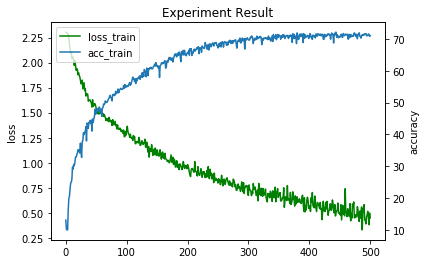

In [30]:
fig,ax1=plt.subplots()
ax2=ax1.twinx()
line1=ax1.plot(np.array(loss_train),color='g',label='loss_train')
line2=ax2.plot([i*1 for i in range(len(acc_train))],acc_train,label='acc_train')
lines=line1+line2
ax1.set_ylabel("loss")
ax2.set_ylabel("accuracy")
plt.xlabel('Epoch')
plt.title('Experiment Result')
plt.legend(lines,['loss_train','acc_train'])
plt.show()

In [31]:
PATH = './data/CIFAR_iid_net_moreparam.pth'
torch.save( FedAvg_model.state_dict(), PATH)

cifar10 FedAvg Non-iid로 학습


In [37]:
device=torch.device('cuda')
FedAvg_model=Net().cuda()
criterion= nn.CrossEntropyLoss().to(device)
FedAvg_model.train()
epoch_loss = []

# Set optimizer for the local updates

optimizer = torch.optim.SGD(FedAvg_model.parameters(), lr=0.001,
                                momentum=0.9)
global_epoch=5001

In [38]:
weight_saved=FedAvg_model.state_dict()

In [39]:
C=0.05
num_clients=100
CIFAR_noniid_dataset=cifar_dirichlet(trainset, num_clients)
#CIFAR_iid_dataset=cifar_iid(trainset, num_clients)
loss_train = []
acc_train=[]

torch.int64


In [40]:
for epoch in range(global_epoch):
    local_weight=[]
    local_loss=[]
    m=max(int(C*num_clients),1)
    selected_user=np.random.choice(range(num_clients),m,replace=False)
    print(f"This is global {epoch} epoch")
    for user in selected_user:
        local_setting=LocalUpdate(lr=0.1,local_epoch=1,device=device,batch_size=40,dataset=trainset, idxs=CIFAR_noniid_dataset[user])
        weight,loss=local_setting.train(net=copy.deepcopy(FedAvg_model).to(device))
        local_weight.append(copy.deepcopy(weight))
        #print(local_weight[0].keys())
        local_loss.append(copy.deepcopy(loss))
    FedAvg_weight=copy.deepcopy(local_weight[0])
    for key in FedAvg_weight.keys():
        for i in range(1,len(local_weight)):
            FedAvg_weight[key]+=local_weight[i][key]
        FedAvg_weight[key]/=len(local_weight)
    FedAvg_model.load_state_dict(FedAvg_weight)
    loss_avg = sum(local_loss) / len(local_loss)
    print(' Average loss {:.3f}'.format( loss_avg))
    loss_train.append(loss_avg)
    if epoch%1==0:
        for j in range(1):
            FedAvg_model.eval()         
            correct = 0
            total = 0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data[0].to(device), data[1].to(device)
                    outputs = FedAvg_model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %f %%' % (
                100 * correct / float(total)))
        acc_train.append(100 * correct / float(total))
 
    FedAvg_model.train()

This is global 0 epoch


/home/dana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


 Average loss 1.897
Accuracy of the network on the 10000 test images: 16.590000 %
This is global 1 epoch
 Average loss 1.754
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2 epoch
 Average loss 1.864
Accuracy of the network on the 10000 test images: 15.600000 %
This is global 3 epoch
 Average loss 1.781
Accuracy of the network on the 10000 test images: 10.770000 %
This is global 4 epoch
 Average loss 1.621
Accuracy of the network on the 10000 test images: 17.890000 %
This is global 5 epoch
 Average loss 1.673
Accuracy of the network on the 10000 test images: 14.820000 %
This is global 6 epoch
 Average loss 1.631
Accuracy of the network on the 10000 test images: 16.970000 %
This is global 7 epoch
 Average loss 1.615
Accuracy of the network on the 10000 test images: 18.880000 %
This is global 8 epoch
 Average loss 1.385
Accuracy of the network on the 10000 test images: 21.300000 %
This is global 9 epoch
 Average loss 1.528
Accuracy of the network on the 1000

 Average loss 1.022
Accuracy of the network on the 10000 test images: 38.440000 %
This is global 79 epoch
 Average loss 1.093
Accuracy of the network on the 10000 test images: 44.720000 %
This is global 80 epoch
 Average loss 1.085
Accuracy of the network on the 10000 test images: 42.130000 %
This is global 81 epoch
 Average loss 1.142
Accuracy of the network on the 10000 test images: 40.090000 %
This is global 82 epoch
 Average loss 1.083
Accuracy of the network on the 10000 test images: 44.540000 %
This is global 83 epoch
 Average loss 1.028
Accuracy of the network on the 10000 test images: 45.440000 %
This is global 84 epoch
 Average loss 1.089
Accuracy of the network on the 10000 test images: 44.670000 %
This is global 85 epoch
 Average loss 1.118
Accuracy of the network on the 10000 test images: 46.590000 %
This is global 86 epoch
 Average loss 1.132
Accuracy of the network on the 10000 test images: 43.950000 %
This is global 87 epoch
 Average loss 1.116
Accuracy of the network on

 Average loss 0.777
Accuracy of the network on the 10000 test images: 52.880000 %
This is global 156 epoch
 Average loss 0.882
Accuracy of the network on the 10000 test images: 54.680000 %
This is global 157 epoch
 Average loss 0.871
Accuracy of the network on the 10000 test images: 54.660000 %
This is global 158 epoch
 Average loss 0.791
Accuracy of the network on the 10000 test images: 52.800000 %
This is global 159 epoch
 Average loss 0.738
Accuracy of the network on the 10000 test images: 53.070000 %
This is global 160 epoch
 Average loss 0.850
Accuracy of the network on the 10000 test images: 45.540000 %
This is global 161 epoch
 Average loss 0.876
Accuracy of the network on the 10000 test images: 53.330000 %
This is global 162 epoch
 Average loss 0.821
Accuracy of the network on the 10000 test images: 54.440000 %
This is global 163 epoch
 Average loss 0.876
Accuracy of the network on the 10000 test images: 51.960000 %
This is global 164 epoch
 Average loss 0.780
Accuracy of the n

 Average loss 0.672
Accuracy of the network on the 10000 test images: 61.170000 %
This is global 233 epoch
 Average loss 0.747
Accuracy of the network on the 10000 test images: 60.570000 %
This is global 234 epoch
 Average loss 0.790
Accuracy of the network on the 10000 test images: 62.440000 %
This is global 235 epoch
 Average loss 0.820
Accuracy of the network on the 10000 test images: 62.140000 %
This is global 236 epoch
 Average loss 0.740
Accuracy of the network on the 10000 test images: 58.910000 %
This is global 237 epoch
 Average loss 0.641
Accuracy of the network on the 10000 test images: 57.680000 %
This is global 238 epoch
 Average loss 0.684
Accuracy of the network on the 10000 test images: 55.740000 %
This is global 239 epoch
 Average loss 0.624
Accuracy of the network on the 10000 test images: 55.950000 %
This is global 240 epoch
 Average loss 0.640
Accuracy of the network on the 10000 test images: 57.860000 %
This is global 241 epoch
 Average loss 0.664
Accuracy of the n

 Average loss 0.490
Accuracy of the network on the 10000 test images: 64.290000 %
This is global 310 epoch
 Average loss 0.509
Accuracy of the network on the 10000 test images: 64.720000 %
This is global 311 epoch
 Average loss 0.491
Accuracy of the network on the 10000 test images: 61.160000 %
This is global 312 epoch
 Average loss 0.595
Accuracy of the network on the 10000 test images: 61.010000 %
This is global 313 epoch
 Average loss 0.549
Accuracy of the network on the 10000 test images: 63.670000 %
This is global 314 epoch
 Average loss 0.734
Accuracy of the network on the 10000 test images: 58.520000 %
This is global 315 epoch
 Average loss 0.624
Accuracy of the network on the 10000 test images: 58.590000 %
This is global 316 epoch
 Average loss 0.680
Accuracy of the network on the 10000 test images: 63.580000 %
This is global 317 epoch
 Average loss 0.623
Accuracy of the network on the 10000 test images: 66.110000 %
This is global 318 epoch
 Average loss 0.532
Accuracy of the n

 Average loss 0.379
Accuracy of the network on the 10000 test images: 64.460000 %
This is global 387 epoch
 Average loss 0.596
Accuracy of the network on the 10000 test images: 55.240000 %
This is global 388 epoch
 Average loss 0.505
Accuracy of the network on the 10000 test images: 62.870000 %
This is global 389 epoch
 Average loss 0.568
Accuracy of the network on the 10000 test images: 55.600000 %
This is global 390 epoch
 Average loss 0.569
Accuracy of the network on the 10000 test images: 64.340000 %
This is global 391 epoch
 Average loss 0.533
Accuracy of the network on the 10000 test images: 66.000000 %
This is global 392 epoch
 Average loss 0.467
Accuracy of the network on the 10000 test images: 59.450000 %
This is global 393 epoch
 Average loss 0.572
Accuracy of the network on the 10000 test images: 63.810000 %
This is global 394 epoch
 Average loss 0.523
Accuracy of the network on the 10000 test images: 63.790000 %
This is global 395 epoch
 Average loss 0.605
Accuracy of the n

 Average loss 0.478
Accuracy of the network on the 10000 test images: 65.210000 %
This is global 464 epoch
 Average loss 0.441
Accuracy of the network on the 10000 test images: 66.020000 %
This is global 465 epoch
 Average loss 0.345
Accuracy of the network on the 10000 test images: 52.160000 %
This is global 466 epoch
 Average loss 0.781
Accuracy of the network on the 10000 test images: 66.410000 %
This is global 467 epoch
 Average loss 0.478
Accuracy of the network on the 10000 test images: 67.130000 %
This is global 468 epoch
 Average loss 0.484
Accuracy of the network on the 10000 test images: 66.460000 %
This is global 469 epoch
 Average loss 0.426
Accuracy of the network on the 10000 test images: 66.560000 %
This is global 470 epoch
 Average loss 0.523
Accuracy of the network on the 10000 test images: 67.500000 %
This is global 471 epoch
 Average loss 0.527
Accuracy of the network on the 10000 test images: 66.660000 %
This is global 472 epoch
 Average loss 0.511
Accuracy of the n

 Average loss 0.429
Accuracy of the network on the 10000 test images: 66.700000 %
This is global 541 epoch
 Average loss 0.402
Accuracy of the network on the 10000 test images: 66.790000 %
This is global 542 epoch
 Average loss 0.370
Accuracy of the network on the 10000 test images: 62.800000 %
This is global 543 epoch
 Average loss 0.423
Accuracy of the network on the 10000 test images: 63.470000 %
This is global 544 epoch
 Average loss 0.414
Accuracy of the network on the 10000 test images: 68.580000 %
This is global 545 epoch
 Average loss 0.287
Accuracy of the network on the 10000 test images: 67.570000 %
This is global 546 epoch
 Average loss 0.416
Accuracy of the network on the 10000 test images: 66.910000 %
This is global 547 epoch
 Average loss 0.397
Accuracy of the network on the 10000 test images: 63.400000 %
This is global 548 epoch
 Average loss 0.321
Accuracy of the network on the 10000 test images: 68.340000 %
This is global 549 epoch
 Average loss 0.363
Accuracy of the n

 Average loss 0.338
Accuracy of the network on the 10000 test images: 61.990000 %
This is global 618 epoch
 Average loss 0.357
Accuracy of the network on the 10000 test images: 66.870000 %
This is global 619 epoch
 Average loss 0.340
Accuracy of the network on the 10000 test images: 69.330000 %
This is global 620 epoch
 Average loss 0.368
Accuracy of the network on the 10000 test images: 67.990000 %
This is global 621 epoch
 Average loss 0.389
Accuracy of the network on the 10000 test images: 68.310000 %
This is global 622 epoch
 Average loss 0.277
Accuracy of the network on the 10000 test images: 67.320000 %
This is global 623 epoch
 Average loss 0.462
Accuracy of the network on the 10000 test images: 64.140000 %
This is global 624 epoch
 Average loss 0.238
Accuracy of the network on the 10000 test images: 69.000000 %
This is global 625 epoch
 Average loss 0.268
Accuracy of the network on the 10000 test images: 66.530000 %
This is global 626 epoch
 Average loss 0.382
Accuracy of the n

 Average loss 0.384
Accuracy of the network on the 10000 test images: 67.560000 %
This is global 695 epoch
 Average loss 0.329
Accuracy of the network on the 10000 test images: 63.890000 %
This is global 696 epoch
 Average loss 0.267
Accuracy of the network on the 10000 test images: 66.620000 %
This is global 697 epoch
 Average loss 0.375
Accuracy of the network on the 10000 test images: 68.830000 %
This is global 698 epoch
 Average loss 0.260
Accuracy of the network on the 10000 test images: 68.090000 %
This is global 699 epoch
 Average loss 0.241
Accuracy of the network on the 10000 test images: 66.870000 %
This is global 700 epoch
 Average loss 0.237
Accuracy of the network on the 10000 test images: 66.180000 %
This is global 701 epoch
 Average loss 0.356
Accuracy of the network on the 10000 test images: 66.840000 %
This is global 702 epoch
 Average loss 0.296
Accuracy of the network on the 10000 test images: 67.850000 %
This is global 703 epoch
 Average loss 0.237
Accuracy of the n

 Average loss 0.285
Accuracy of the network on the 10000 test images: 67.090000 %
This is global 772 epoch
 Average loss 0.255
Accuracy of the network on the 10000 test images: 67.150000 %
This is global 773 epoch
 Average loss 0.220
Accuracy of the network on the 10000 test images: 68.810000 %
This is global 774 epoch
 Average loss 0.204
Accuracy of the network on the 10000 test images: 66.810000 %
This is global 775 epoch
 Average loss 0.253
Accuracy of the network on the 10000 test images: 67.250000 %
This is global 776 epoch
 Average loss 0.195
Accuracy of the network on the 10000 test images: 66.810000 %
This is global 777 epoch
 Average loss 0.194
Accuracy of the network on the 10000 test images: 69.110000 %
This is global 778 epoch
 Average loss 0.232
Accuracy of the network on the 10000 test images: 67.210000 %
This is global 779 epoch
 Average loss 0.266
Accuracy of the network on the 10000 test images: 65.390000 %
This is global 780 epoch
 Average loss 0.229
Accuracy of the n

 Average loss 0.207
Accuracy of the network on the 10000 test images: 67.480000 %
This is global 849 epoch
 Average loss 0.144
Accuracy of the network on the 10000 test images: 68.040000 %
This is global 850 epoch
 Average loss 0.159
Accuracy of the network on the 10000 test images: 65.310000 %
This is global 851 epoch
 Average loss 0.287
Accuracy of the network on the 10000 test images: 67.600000 %
This is global 852 epoch
 Average loss 0.193
Accuracy of the network on the 10000 test images: 63.090000 %
This is global 853 epoch
 Average loss 0.238
Accuracy of the network on the 10000 test images: 66.510000 %
This is global 854 epoch
 Average loss 0.199
Accuracy of the network on the 10000 test images: 66.420000 %
This is global 855 epoch
 Average loss 0.209
Accuracy of the network on the 10000 test images: 68.660000 %
This is global 856 epoch
 Average loss 0.165
Accuracy of the network on the 10000 test images: 68.080000 %
This is global 857 epoch
 Average loss 0.190
Accuracy of the n

 Average loss 0.110
Accuracy of the network on the 10000 test images: 66.510000 %
This is global 926 epoch
 Average loss 0.165
Accuracy of the network on the 10000 test images: 67.660000 %
This is global 927 epoch
 Average loss 0.100
Accuracy of the network on the 10000 test images: 66.610000 %
This is global 928 epoch
 Average loss 0.181
Accuracy of the network on the 10000 test images: 67.390000 %
This is global 929 epoch
 Average loss 0.173
Accuracy of the network on the 10000 test images: 68.030000 %
This is global 930 epoch
 Average loss 0.144
Accuracy of the network on the 10000 test images: 67.570000 %
This is global 931 epoch
 Average loss 0.108
Accuracy of the network on the 10000 test images: 66.890000 %
This is global 932 epoch
 Average loss 0.134
Accuracy of the network on the 10000 test images: 68.210000 %
This is global 933 epoch
 Average loss 0.222
Accuracy of the network on the 10000 test images: 67.030000 %
This is global 934 epoch
 Average loss 0.138
Accuracy of the n

 Average loss 0.192
Accuracy of the network on the 10000 test images: 67.310000 %
This is global 1003 epoch
 Average loss 0.134
Accuracy of the network on the 10000 test images: 66.460000 %
This is global 1004 epoch
 Average loss 0.189
Accuracy of the network on the 10000 test images: 64.670000 %
This is global 1005 epoch
 Average loss 0.107
Accuracy of the network on the 10000 test images: 67.390000 %
This is global 1006 epoch
 Average loss 0.125
Accuracy of the network on the 10000 test images: 64.980000 %
This is global 1007 epoch
 Average loss 0.101
Accuracy of the network on the 10000 test images: 65.670000 %
This is global 1008 epoch
 Average loss 0.158
Accuracy of the network on the 10000 test images: 66.140000 %
This is global 1009 epoch
 Average loss 0.167
Accuracy of the network on the 10000 test images: 64.100000 %
This is global 1010 epoch
 Average loss 0.215
Accuracy of the network on the 10000 test images: 66.280000 %
This is global 1011 epoch
 Average loss 0.117
Accuracy

 Average loss 0.047
Accuracy of the network on the 10000 test images: 67.850000 %
This is global 1079 epoch
 Average loss 0.082
Accuracy of the network on the 10000 test images: 68.420000 %
This is global 1080 epoch
 Average loss 0.142
Accuracy of the network on the 10000 test images: 64.820000 %
This is global 1081 epoch
 Average loss 0.124
Accuracy of the network on the 10000 test images: 65.040000 %
This is global 1082 epoch
 Average loss 0.255
Accuracy of the network on the 10000 test images: 66.890000 %
This is global 1083 epoch
 Average loss 0.116
Accuracy of the network on the 10000 test images: 66.530000 %
This is global 1084 epoch
 Average loss 0.102
Accuracy of the network on the 10000 test images: 65.870000 %
This is global 1085 epoch
 Average loss 0.135
Accuracy of the network on the 10000 test images: 66.440000 %
This is global 1086 epoch
 Average loss 0.120
Accuracy of the network on the 10000 test images: 68.060000 %
This is global 1087 epoch
 Average loss 0.112
Accuracy

 Average loss 0.071
Accuracy of the network on the 10000 test images: 67.830000 %
This is global 1155 epoch
 Average loss 0.072
Accuracy of the network on the 10000 test images: 67.750000 %
This is global 1156 epoch
 Average loss 0.072
Accuracy of the network on the 10000 test images: 68.390000 %
This is global 1157 epoch
 Average loss 0.071
Accuracy of the network on the 10000 test images: 67.030000 %
This is global 1158 epoch
 Average loss 0.085
Accuracy of the network on the 10000 test images: 67.560000 %
This is global 1159 epoch
 Average loss 0.080
Accuracy of the network on the 10000 test images: 67.840000 %
This is global 1160 epoch
 Average loss 0.070
Accuracy of the network on the 10000 test images: 68.060000 %
This is global 1161 epoch
 Average loss 0.056
Accuracy of the network on the 10000 test images: 68.230000 %
This is global 1162 epoch
 Average loss 0.067
Accuracy of the network on the 10000 test images: 65.070000 %
This is global 1163 epoch
 Average loss 0.126
Accuracy

 Average loss 0.050
Accuracy of the network on the 10000 test images: 67.670000 %
This is global 1231 epoch
 Average loss 0.032
Accuracy of the network on the 10000 test images: 67.750000 %
This is global 1232 epoch
 Average loss 0.166
Accuracy of the network on the 10000 test images: 67.800000 %
This is global 1233 epoch
 Average loss 0.063
Accuracy of the network on the 10000 test images: 68.540000 %
This is global 1234 epoch
 Average loss 0.064
Accuracy of the network on the 10000 test images: 68.250000 %
This is global 1235 epoch
 Average loss 0.068
Accuracy of the network on the 10000 test images: 68.390000 %
This is global 1236 epoch
 Average loss 0.052
Accuracy of the network on the 10000 test images: 67.590000 %
This is global 1237 epoch
 Average loss 0.188
Accuracy of the network on the 10000 test images: 66.510000 %
This is global 1238 epoch
 Average loss 0.098
Accuracy of the network on the 10000 test images: 66.880000 %
This is global 1239 epoch
 Average loss 0.106
Accuracy

 Average loss 0.239
Accuracy of the network on the 10000 test images: 67.290000 %
This is global 1307 epoch
 Average loss 0.194
Accuracy of the network on the 10000 test images: 65.570000 %
This is global 1308 epoch
 Average loss 0.061
Accuracy of the network on the 10000 test images: 67.460000 %
This is global 1309 epoch
 Average loss 0.064
Accuracy of the network on the 10000 test images: 66.920000 %
This is global 1310 epoch
 Average loss 0.205
Accuracy of the network on the 10000 test images: 67.510000 %
This is global 1311 epoch
 Average loss 0.071
Accuracy of the network on the 10000 test images: 66.370000 %
This is global 1312 epoch
 Average loss 0.043
Accuracy of the network on the 10000 test images: 67.260000 %
This is global 1313 epoch
 Average loss 0.057
Accuracy of the network on the 10000 test images: 68.020000 %
This is global 1314 epoch
 Average loss 0.071
Accuracy of the network on the 10000 test images: 66.930000 %
This is global 1315 epoch
 Average loss 0.078
Accuracy

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1384 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1385 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1386 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1387 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1388 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1389 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1390 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1391 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1392 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1462 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1463 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1464 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1465 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1466 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1467 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1468 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1469 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1470 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1540 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1541 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1542 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1543 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1544 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1545 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1546 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1547 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1548 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1618 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1619 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1620 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1621 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1622 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1623 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1624 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1625 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1626 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1696 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1697 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1698 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1699 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1700 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1701 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1702 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1703 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1704 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1774 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1775 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1776 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1777 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1778 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1779 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1780 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1781 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1782 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1852 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1853 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1854 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1855 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1856 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1857 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1858 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1859 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1860 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1930 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1931 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1932 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1933 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1934 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1935 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1936 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1937 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1938 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2008 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2009 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2010 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2011 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2012 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2013 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2014 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2015 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2016 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2086 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2087 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2088 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2089 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2090 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2091 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2092 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2093 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2094 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2164 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2165 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2166 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2167 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2168 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2169 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2170 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2171 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2172 epoch
 Average loss nan
Accuracy of the network on t

 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2242 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2243 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2244 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2245 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2246 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2247 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2248 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2249 epoch
 Average loss nan
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2250 epoch
 Average loss nan
Accuracy of the network on t

Exception ignored in: <function _after_fork at 0x7fdac0e1a710>
Traceback (most recent call last):
  File "/home/dana/anaconda3/lib/python3.7/threading.py", line 1368, in _after_fork


KeyboardInterrupt: 

    thread._reset_internal_locks(False)
  File "/home/dana/anaconda3/lib/python3.7/threading.py", line 811, in _reset_internal_locks
    self._started._reset_internal_locks()
  File "/home/dana/anaconda3/lib/python3.7/threading.py", line 505, in _reset_internal_locks
    self._cond.__init__(Lock())
  File "/home/dana/anaconda3/lib/python3.7/threading.py", line 221, in __init__
    self.acquire = lock.acquire
KeyboardInterrupt: 


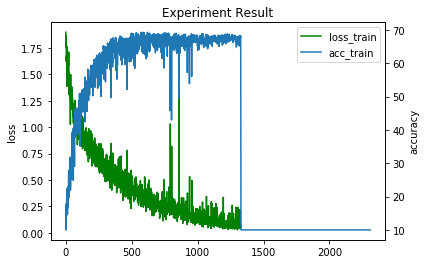

In [41]:
fig,ax1=plt.subplots()
ax2=ax1.twinx()
line1=ax1.plot(np.array(loss_train),color='g',label='loss_train')
line2=ax2.plot([i*1 for i in range(len(acc_train))],acc_train,label='acc_train')
lines=line1+line2
ax1.set_ylabel("loss")
ax2.set_ylabel("accuracy")
plt.xlabel('Epoch')
plt.title('Experiment Result')
plt.legend(lines,['loss_train','acc_train'])
plt.show()

In [42]:
PATH = './data/CIFAR_noniid_net_moreparam.pth'
torch.save( FedAvg_model.state_dict(), PATH)

In [43]:
print(max(acc_train))

69.33
